#### animating the scoring logic as a function of elevator height and arm angle
#### 20250203 CJH

In [1]:
# import panel as pn
# pn.extension('matplotlib')  # has to come before other matplotlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output
from ipywidgets import interact, FloatSlider
import time

#### setting up the plot - lots of matplotlib

In [2]:
# set up the plot
# Define plot limits
x_limits = (-20, 40)
y_limits = (0, 90)

# Define static elements of the target structure
target_structure = {
    "base": {"type": "rectangle", "xy": (18, 0), "width": 19.2, "height": 17.8, "color": "gray"},
    "vertical_pipe": {"type": "line", "start": (30.2, 17.9), "end": (30.2, 53.8), "color": "purple"},
    "connector": {"type": "line", "start": (30.2, 53.8), "end": (19.8, 64.6), "color": "purple"},
    "L2": {"type": "line", "start": (30.2, 24.2), "end": (20, 31.2), "color": "purple"},
    "L3": {"type": "line", "start": (29.9, 40.1), "end": (20, 47.1), "color": "purple"},
    "L4": {"type": "line", "start": (19.8, 64.6), "end": (19.8, 71.9), "color": "purple"},
}

# Define the dynamic robot arm parameters
L = 18 + 5.625 # 20.5  # Arm length in inches
robot_offset = 0  # offset of robot from coral 

# these things are pretty much fixed
bumper_size = 36.1  # bumper to bumper size
bumper_y_center = 3.5 # center of bumpers in y
pivot_size = 6  # Size of pivot point box
arm_color = "blue"
end_effector_color = "red"
gamepiece_size = (12, 4)  # Gamepiece dimensions (length, width)
gamepiece_color = "red"

#Plot options
fontsize = 8

# Engagement points  - update this with a full solution below
engagement_positions = {'H1': {'H': 13.64, 'THETA': 24.31, 'offset': 0},
                         'H2': {'H': 17.27, 'THETA': 49.11, 'offset': 0},
                         'H3': {'H': 33.17, 'THETA': 49.11, 'offset': 0},
                         'H4': {'H': 63.0, 'THETA': 40.82, 'offset': -2}}

# in case we want to switch angle definition 
def convert_theta(theta):
    """Convert the angle from the new convention (0° = up, CW positive) to the previous convention."""
    # return theta + 90  # just pass through standard math convention - 0 to the right and CCW positive 
    return theta 
    # return -(theta - 180)


#### how to solve for the optimal starting point for each target - 
* probably does not care about angle of target
* but does need to pull robot back for L4 

In [3]:
# solve for the engagement positions
from scipy.optimize import least_squares

# Define arm length and gamepiece size
L = L  # get this from above
gamepiece_size = (12, 4)  # Gamepiece dimensions (length, width)

# Define target heights and x-coordinates
target_pipes = {
    "H1": {"height": 17.9, "x": 24, 'offset':0},
    "H2": {"height": 31.2, "x": 20, 'offset':0},
    "H3": {"height": 47.1, "x": 20, 'offset':0},
    "H4": {"height": 71.9, "x": 19.8, 'offset':-2},
}

def solve_engagement(H_target, x_target, offset):
    """Solve for H and THETA given the bottom center of the gamepiece must align with (x_target, H_target)."""
    min_height, max_height = 0, 72
    min_theta, max_theta = -25, 80
    def equations(vars):
        H, theta = vars
        theta = np.radians(theta)

        # Compute arm endpoint
        arm_x = L * np.cos(theta) + offset
        arm_y = H + L * np.sin(theta) + offset

        # Compute gamepiece center (2 inches along the arm direction)
        gamepiece_x = arm_x + 2 * np.cos(theta)
        gamepiece_y = arm_y + 2 * np.sin(theta)

        # Compute bottom center of the gamepiece (6 inches perpendicular to the arm direction)
        bottom_x = gamepiece_x  + 6 * np.cos(theta - np.radians(90))
        bottom_y = gamepiece_y  + 6 * np.sin(theta - np.radians(90))

        return [bottom_x - x_target, bottom_y - H_target]

    # Use least squares optimization for better stability
    initial_guess = [H_target - 10 , 45]  # Start with a reasonable guess
    result = least_squares(equations, initial_guess, bounds=([min_height, min_theta], [max_height, max_theta]))
    print(f'for target at ({x_target:.1f}, {H_target:.1f}): H, Theta is ({result.x[0]:.1f}, {result.x[1]:.1f})')

    return {"H": float(round(result.x[0],2)), "THETA": float(round(result.x[1],2)), 'offset':offset}

# Compute engagement positions for all targets
engagement_positions = {key: solve_engagement(val["height"], val["x"], val["offset"]) for key, val in target_pipes.items()}

# Print engagement positions
engagement_positions


for target at (24.0, 17.9): H, Theta is (7.1, 37.4)
for target at (20.0, 31.2): H, Theta is (14.1, 53.7)
for target at (20.0, 47.1): H, Theta is (30.0, 53.7)
for target at (19.8, 71.9): H, Theta is (59.2, 47.3)


{'H1': {'H': 7.1, 'THETA': 37.41, 'offset': 0},
 'H2': {'H': 14.09, 'THETA': 53.72, 'offset': 0},
 'H3': {'H': 29.99, 'THETA': 53.72, 'offset': 0},
 'H4': {'H': 59.16, 'THETA': 47.25, 'offset': -2}}

#### defining plots and animations

In [4]:
def draw_robot(ax, H, THETA, time=0, offset=0, static=False):
    """Draw the robot arm and gamepiece given H (height) and THETA (angle from vertical)."""
    THETA = convert_theta(THETA)  # Convert theta to the correct convention
    ax.clear()
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_aspect("equal")
    ax.set_title(f"robot arm placement at t={time:.2f}s", fontsize=fontsize)
    
    # Draw static target structure
    for name, part in target_structure.items():
        if part["type"] == "rectangle":
            ax.add_patch(patches.Rectangle(part["xy"], part["width"], part["height"], color=part["color"], alpha=0.5))
        elif part["type"] == "line":
            ax.plot([part["start"][0], part["end"][0]], [part["start"][1], part["end"][1]], color=part["color"], linewidth=2)
            ax.plot(part["start"][0], part["start"][1], 'ko', markersize=2, fillstyle='none')  # Open circle at start
            ax.plot(part["end"][0], part["end"][1], 'ko', markersize=2, fillstyle='none')  # Open circle at end

    # Draw elevator (black vertical line from (0,0) to (0,H))  
    ax.plot([offset, offset], [0, H], color="black", linewidth=2)
    # draw bumpers
    ax.add_patch(patches.Rectangle((-bumper_size/2 + offset, bumper_y_center - 5/2), bumper_size, 5, edgecolor="green", facecolor="none", linewidth=2))
    
    # Draw pivot point
    ax.add_patch(patches.Rectangle((-pivot_size/2 + offset, H - pivot_size/2), pivot_size, pivot_size, edgecolor="black", facecolor="none", linewidth=2))
    ax.plot(offset, H, "bo", markersize=6)  # Pivot point in blue
    
    # Compute arm endpoint
    arm_x = L * np.cos(np.radians(THETA)) + offset
    arm_y = H + L * np.sin(np.radians(THETA)) + offset
    ax.plot([offset, arm_x], [H, arm_y], color=arm_color, linewidth=2)
    ax.plot(arm_x, arm_y, "bo", markersize=3)  # End effector in blue
    
    # Compute gamepiece rectangle center at end of the arm + 2 inches along the arm direction
    gamepiece_center_x = arm_x + (gamepiece_size[1] / 2)  * np.cos(np.radians(THETA))
    gamepiece_center_y = arm_y + (gamepiece_size[1] / 2)  * np.sin(np.radians(THETA))
    ax.plot(gamepiece_center_x, gamepiece_center_y, "go", markersize=3)  # Coral center in green

    # getting the corner of the box is a pain
    coral_corner = (gamepiece_center_x + (gamepiece_size[0] / 2) * np.sin(np.radians(THETA)) + (gamepiece_size[1] / 2)  * np.cos(np.radians(THETA)),
                   gamepiece_center_y - (gamepiece_size[0] / 2) * np.cos(np.radians(THETA)) + (gamepiece_size[1] / 2)  * np.sin(np.radians(THETA)))
    # ax.plot(*coral_corner, "yo", markersize=3)  # Coral corner in yellow
    
    gamepiece_rect = patches.Rectangle(
        xy=coral_corner,
        width=gamepiece_size[0],
        height=gamepiece_size[1],
        angle=THETA+90,
        edgecolor=gamepiece_color,
        facecolor="none",
        linewidth=2
    )
    ax.add_patch(gamepiece_rect)
    
    # Annotate time
    ax.text(-15, 85, f"time: {time:.2f}s  h:{H:.1f}  theta:{THETA:2.1f}", fontsize=fontsize, bbox=dict(facecolor='white', edgecolor='black'))
    if static:
        return ax
    else:
        plt.draw()

def animate_trajectory(trajectory):
    """Animate the robot arm movement over time in Jupyter Notebook."""
    fig, ax = plt.subplots(figsize=(6, 6))

    for t, H, THETA, offset in zip(trajectory["time"], trajectory["H"], trajectory["THETA"], trajectory["offset"]):
        draw_robot(ax, H, THETA, t, offset)
        display(fig)  # Explicitly display updated figure
        clear_output(wait=True)  # Remove previous frame for smooth animation
        # time.sleep(0.01)  # Control animation speed

    plt.show()  # Keep the final frame visible


def update_plot(H, THETA, offset, fig, ax, panel_obj):
    """Update the plot dynamically and trigger Panel update."""
    draw_robot(ax, H, THETA, offset, static=True)
    panel_obj.param.trigger('object')  # Force Panel to refresh
    return fig

#### using the plots

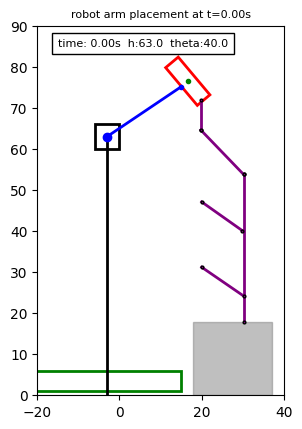

In [5]:
# Example usage: Draw static arm at H, THETA
draw_robot(plt.gca(), H=63, THETA=40, offset=-3)

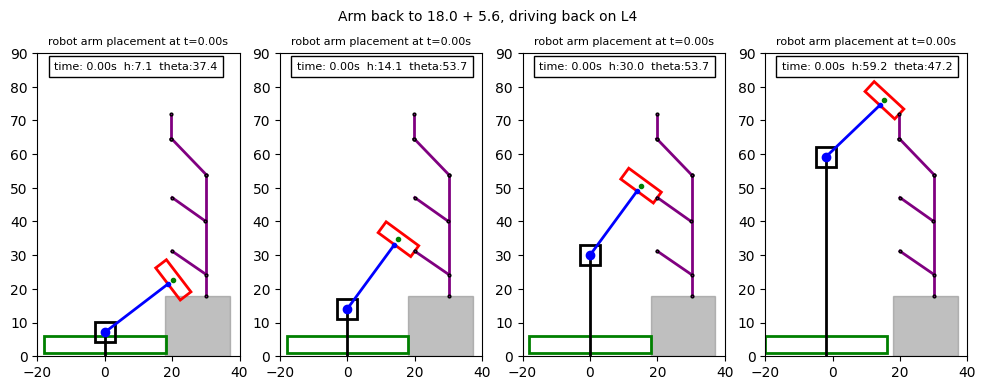

In [6]:
# show all four locations of engagement
fig, axs = plt.subplots(1, 4, figsize=(12, 10))  # Create a 2x2 grid of subplots
ax_flat = axs.flatten()  # Flatten the 2D array of axes into a list
for ix, (key, value) in enumerate(engagement_positions.items()):
    draw_robot(ax_flat[ix], **value, static=True)  # Pass the specific subplot axis
plt.suptitle(f'Arm back to {L-5.625} + 5.6, driving back on L4', y=0.69, fontsize=10)
plt.show()  

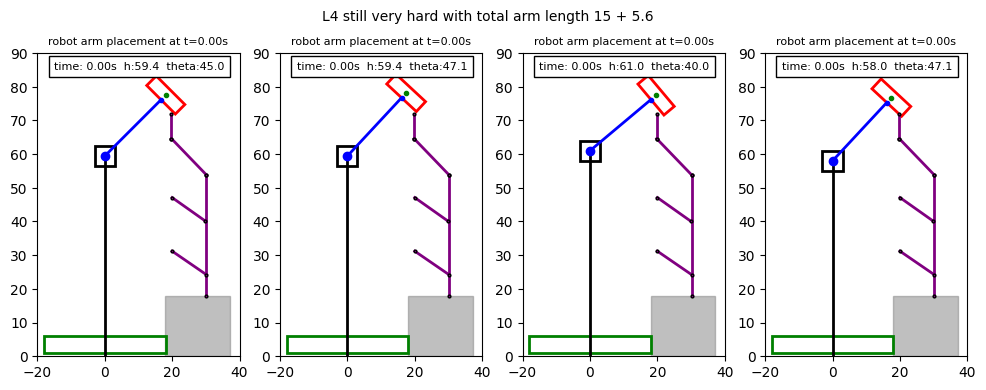

In [7]:
# Engagement points
test_positions = {'H40': {'H': 59.42, 'THETA': 45},
                     'H41': {'H': 59.42, 'THETA': 47.08},
                     'H42': {'H': 61, 'THETA': 40},
                     'H43': {'H': 58, 'THETA': 47.08},}

# show all four locations of engagement
fig, axs = plt.subplots(1, 4, figsize=(12, 10))  # Create a 2x2 grid of subplots
ax_flat = axs.flatten()  # Flatten the 2D array of axes into a list
for ix, (key, value) in enumerate(test_positions.items()):
    draw_robot(ax_flat[ix], **value, static=True)  # Pass the specific subplot axis
plt.suptitle('L4 still very hard with total arm length 15 + 5.6', y=0.69, fontsize=10)
plt.show()  

#### play with a trajectory

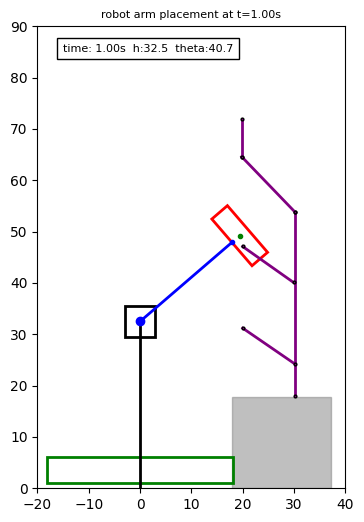

In [9]:
steps = 40
# choose a target
target = 'H3'
start_h = engagement_positions[target]['H']
start_theta = engagement_positions[target]['THETA']
offset = engagement_positions[target]['offset']

# initial step down
times = np.linspace(0,.5,steps)
heights = np.linspace(start_h + 5, start_h, steps)
angles = np.linspace(90, start_theta, steps)
# engulfing
times = np.append(times, np.linspace(0.5,1,steps))
step_up = 2.5 if target != 'H4' else -1
delta_theta = -13 if target != 'H4' else -4
heights = np.append(heights, np.linspace(start_h, start_h + step_up, steps))
angles = np.append(angles, np.linspace(start_theta, start_theta + delta_theta, steps))
offsets = np.ones(len(times)) * offset
heights = np.clip(heights, 0, 63.5)
trajectory = {"time": times, "H": heights, "THETA": angles, 'offset':offsets}
animate_trajectory(trajectory)

In [20]:
# Panel-based interactive UI
# fig, ax = plt.subplots(figsize=(6, 9))
# slider_H = pn.widgets.FloatSlider(name='H', start=10, end=72, step=0.5, value=30)
# slider_THETA = pn.widgets.FloatSlider(name='THETA', start=-15, end=90, step=1, value=0)
# slider_offset = pn.widgets.FloatSlider(name='offset', start=10, end=64, step=0.5, value=30)
# interactive_panel = pn.pane.Matplotlib(fig, tight=True, width=500)
# interactive_panel.object = pn.bind(update_plot, H=slider_H, THETA=slider_THETA, offset=slider_offset, fig=fig, ax=ax, panel_obj=interactive_panel)

# dashboard = pn.Column(interactive_panel, slider_H, slider_THETA, slider_offset)
# dashboard.servable()